**WIC 2017-07-25** - hacked out of Peter Yoachim's **CrowdingMetrics.ipynb** to assemble crowding limiting magnitudes and m5coadd for each filter.

We now have metrics that use the stellar luminosity function maps to compute the errors that will result from stellar crowding.

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.maps as maps

In [40]:
# pieces we need to extract spatial information
import healpy as hp
import healpyUtils
import numpy as np

In [37]:
# astropy manipulation
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord
from astropy import units as u

In [25]:
# Set up the database connection
opsdb = db.OpsimDatabase('minion_1016_sqlite.db')
outDir = 'crowding_test_2017-07-25'
resultsDb = db.ResultsDb(outDir=outDir)
#nside = 64

For the CrowdingMetric, one sets the acceptable magnitude uncertainty, and the metric finds the magnitude star that will have that uncertainty given the crowding.  

In [47]:
thisFilter = 'r'
nside = 64
tMax = 730

In [26]:
bundleList = []
metric = metrics.CrowdingMetric(crowding_error=0.05, seeingCol='FWHMeff')

In [27]:
slicer = slicers.HealpixSlicer(nside=nside, useCache=False)
sql = 'filter="%s" and night < %i' % (thisFilter, tMax)
plotDict={'colorMax':27.}
bundle = metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict)
bundleList.append(bundle)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [28]:
# take the coadded depth as a second metric
metricCoadd = metrics.Coaddm5Metric()
bundleCoadd = metricBundles.MetricBundle(metricCoadd,slicer,sql,plotDict=plotDict)
bundleList.append(bundleCoadd)

In [29]:
bundleDict = metricBundles.makeBundlesDictFromList(bundleList)

Querying database with constraint filter="r" and night < 730
Found 91416 visits
Running:  ['opsim_CoaddM5_r_and_night_lt_730_HEAL', 'opsim_Crowding_To_Precision_r_and_night_lt_730_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "filter="r" and night < 730" constraint now.
Plotting complete.


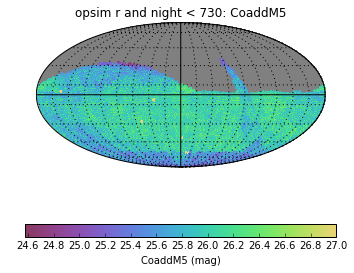

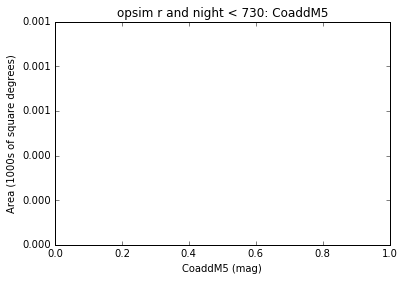

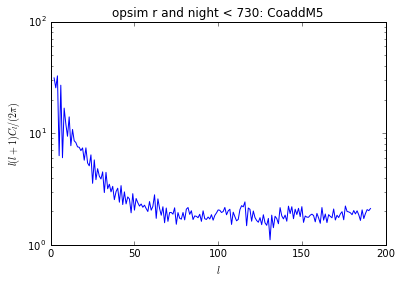

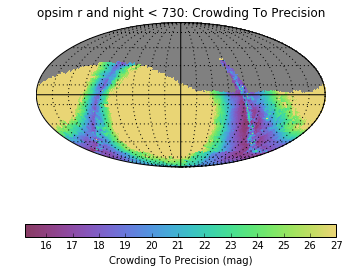

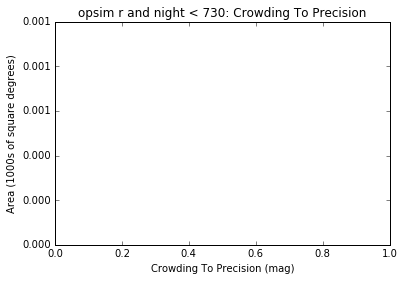

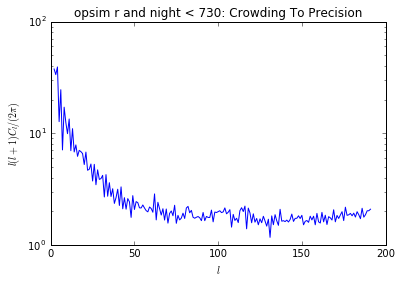

In [30]:
bgroup = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)

### Accessing the values we've just produced ###

In [49]:
# names of bundles for easier retrieval
nameDepth = 'opsim_CoaddM5_%s_and_night_lt_%i_HEAL' % (thisFilter, tMax)
nameCrowd = 'opsim_Crowding_To_Precision_%s_and_night_lt_%i_HEAL' % (thisFilter, tMax)

In [50]:
# reference for easier exploration
dum = bgroup.bundleDict[nameDepth]

In [51]:
# generate coordinates corresponding to our locations. Ensure consistent with the generated metrics.
npix = dum.metricValues.size
nsideFound = hp.npix2nside(npix)
ra, dec = healpyUtils.hpid2RaDec(nside, np.arange(npix))
cc = SkyCoord(ra=np.copy(ra), dec=np.copy(dec), frame='fk5', unit='deg')

In [53]:
# boolean mask
bVal = ~bgroup.bundleDict[nameDepth].metricValues.mask
print np.sum(bVal)

31116


In [59]:
# generate table
tVals = Table()
tVals['HEALPIX'] = np.arange(npix)
tVals['RA'] = cc.ra.degree
tVals['DE'] = cc.dec.degree
tVals['l'] = cc.galactic.l.degree
tVals['b'] = cc.galactic.b.degree

sCoadd = '%sCoadd' % (thisFilter)
sCrowd = '%sCrowd' % (thisFilter)

tVals[sCoadd] = bgroup.bundleDict[nameDepth].metricValues
tVals[sCrowd] = bgroup.bundleDict[nameCrowd].metricValues

tVals['%sCrowdBri' % (thisFilter)] = np.asarray(tVals[sCrowd] < tVals[sCoadd], 'int')

# cut down by mask
tVals = tVals[bVal]

print tVals

HEALPIX     RA           DE       ...     rCoadd    rCrowd rCrowdBri
------- ---------- -------------- ... ------------- ------ ---------
   9814 301.640625   37.168899656 ... 25.0608735125   28.0         0
   9816 304.453125   37.168899656 ... 25.2534068251   28.0         0
   9817 305.859375   37.168899656 ... 25.2534068251   28.0         0
  10070   300.9375  36.4235736423 ... 25.0608735125   28.0         0
  10071  302.34375  36.4235736423 ... 25.0608735125   28.0         0
  10072     303.75  36.4235736423 ... 25.2534068251   28.0         0
  10073  305.15625  36.4235736423 ... 25.2534068251   28.0         0
  10074   306.5625  36.4235736423 ... 25.2534068251   28.0         0
  10325 300.234375  35.6853347127 ... 25.0608735125   28.0         0
  10326 301.640625  35.6853347127 ... 25.0608735125   28.0         0
    ...        ...            ... ...           ...    ...       ...
  49141       67.5 -88.5380288374 ...  25.921547893   22.0         1
  49142      112.5 -88.5380288374 

In [ ]:
# Set metadata and write to disk
tVals.meta['nsideFound'] = nsideFound
tVals.meta['tMax'] = tMax

In [ ]:
# generate output table filename
pathTable='table_uncty_%s_nSide%i_tMax%i.fits' % (thisFilter, nsideFound, tMax)
print pathTable

### Preserved from the original CrowdingMetrics.ipynb ###

The second metric takes a single stellar magnitude and returns the resulting magnitude uncertainty on it, taking the standard 5-sigma depth or the crowding uncertainty, whichever is larger.

In [5]:
bundleList = []
metric = metrics.CrowdingMagUncertMetric()
slicer = slicers.HealpixSlicer(nside=nside, useCache=False)
sql = 'filter="r" and night < 730'
bundle = metricBundles.MetricBundle(metric,slicer,sql)
bundleList.append(bundle)
bundleDict = metricBundles.makeBundlesDictFromList(bundleList)

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes


Querying database with constraint filter="r" and night < 730
Found 97971 visits
Running:  ['opsim_CrowdingMagUncert_r_and_night_lt_730_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with filter="r" and night < 730 sqlconstraint now.
monopole: 0.0136245  dipole: lon: -107.157, lat: -18.1381, amp: 0.0115211
Plotting complete.


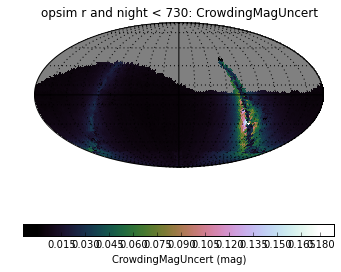

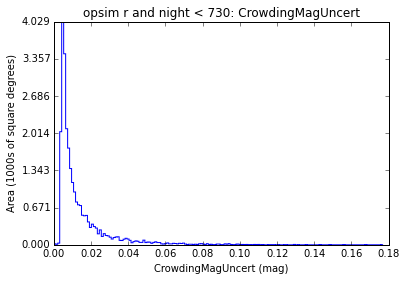

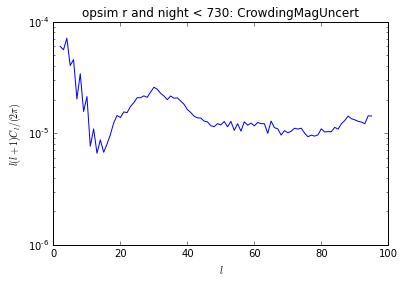

In [6]:
bgroup = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)